# V1 of Predictive Modeling Approach
Whit Blass
September 2022

In [33]:
#import
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import mean_squared_error
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from scipy import stats
import plotly.express as px
from sklearn.neural_network import MLPRegressor
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
simplefilter("ignore", category=ConvergenceWarning)

In [34]:
temp = pd.read_csv('model_data.csv')
temp['late_bin'] = np.where(temp['days_late'] > 0, 1, 0)
temp.to_csv('cat_model.csv')

### Build Data Class to house and clean data

In [35]:
#Arguments to use for data class
features = [
    # 'Material_Group',
    'expected_lead_time',
    'material_order_history',
    'avg_material_late',
    'supplier_material_order_history',
    'avg_supplier_material_late',
    'supplier_total_order_history',
    'avg_supplier_general_late',
    'number_line_items',
    'avg_MOQ',
    'avg_unit_price',
    'avg_min_price',
    # 'delivery_month',
    # 'dayofweek',
    # 'time',
    # 'delivery_season'
]
target = "late_bin"
categorical = [
    'Material_Group',
    'delivery_month',
    'dayofweek',
    'delivery_season'
]
dates = [
    'Scheduled_relevant_delivery_date'
]
split_date = pd.to_datetime("2022-04-01")
split='split_by_time'
path='cat_model.csv'
end_date = pd.to_datetime("2022-05-01")
start_date = pd.to_datetime("2019-01-01")

In [36]:
class IngestionPipe:
    def __init__(self, features:list, target:str, categorical:list, dates:list=None, post_date=None, pre_date=None):
        self.data = None
        self.x_data = None
        self.y_data = None
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.features = features
        self.target = target
        self.categorical = categorical
        self.dates = dates
        self.post_date = post_date
        self.pre_date = pre_date

    def dataAllocation(self,path):
        # TODO: Separate out the x_data and y_data and return each
        # args: string path for .csv file
        # return: None
        # -------------------------------
        print("Beginning ingestion ========---------------------------------------------==========")
        all_data = pd.read_csv(path)
        if self.dates != None:
            for date_feild in self.dates:
                all_data[date_feild] = pd.to_datetime(all_data[date_feild], format='%Y-%m-%d')
        f_data = all_data[self.features+[self.target]]
        self.data = all_data
        print(f"Data size:\n  Number of Rows: {len(all_data)}\n  Number of Features: {len(self.features)}\n  Number of Targets: 1")
        # Get rid of null values
        clean_data = f_data.dropna()
        # get rid of unwanted dates
        print(f"Cutting off date ranges:\n  Before: {self.post_date}\n  After: {self.pre_date}")
        split_index = (all_data['Scheduled_relevant_delivery_date'] <= self.post_date) & (all_data['Scheduled_relevant_delivery_date'] <= self.post_date)
        cleaner_data = clean_data[split_index]
        print("Dropping rows with null values and outside date range:")
        print(f"  Dropped {len(f_data)-len(cleaner_data)} rows\n  {len(cleaner_data)} rows left")
        print("Dropping rows with outlier target variables:")
        outlier_index = (cleaner_data[self.target] <= 10) & (cleaner_data[self.target] >= -10)
        cleanest_data = cleaner_data[outlier_index]
        print(f"  Dropped {len(cleaner_data)-len(cleanest_data)} rows\n  {len(cleanest_data)} rows left")
        # Separate into clean X and clean Y
        x_data = cleanest_data[self.features]
        y_data = cleanest_data[self.target]
        # -------------------------------
        self.x_data = x_data
        self.y_data = y_data
        print('Allocation complete ========---------------------------------------------==========\n')

    def categoricalFixing(self):
        # TODO: create binary feature for all categorical features
        # args: self
        # return: None
        # -------------------------------
        print("Preparing categorical variables ========---------------------------------==========")
        dummy_data = pd.get_dummies(self.x_data, prefix=self.categorical, prefix_sep='-', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)
        print(f'  Number of categorical variables: {len(self.categorical)}')
        print(f'  Number of new binary variables created: {len(dummy_data.columns) - len(self.features) + len(self.categorical)}')
        self.x_data = dummy_data
        self.features = self.x_data.columns
        print(f'  Total number of features now: {len(self.features)}')
        print("Done binarizing variables ========---------------------------------------==========\n")

    def trainSets(self, split, split_date = None):
        # Split data into train and test sets.
        # args: type of split: arguments can be in {random_split, split_by_time}
        # return: None
        # -------------------------------
        print("Separating data into train and test sets ========------------------------==========")
        if split == "random_split":
            x_train, x_test, y_train, y_test = train_test_split(self.x_data,self.y_data, test_size=0.25, train_size=None, random_state=614, shuffle=True, stratify=None)
        if split == "split_by_time":
            split_index = data.data['Scheduled_relevant_delivery_date'] <= split_date
            x_train, x_test = self.x_data[split_index], self.x_data[~split_index]
            y_train, y_test = self.y_data[split_index], self.y_data[~split_index]
        else:
            print('  WARNING: Split type incompatible. Using random split.')
            x_train, x_test, y_train, y_test = train_test_split(self.x_data,self.y_data, test_size=0.25, train_size=None, random_state=614, shuffle=True, stratify=None)
        # Check that data was sampled correctly
        print("  Length of actual training data is",len(y_train))
        print("  Length of actual testing data is",len(y_test))
        # -------------------------------
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        print('Train/Test split complete. ========-------------------------------------==========\n')

    def OverSampling(self):

        os = SMOTE(random_state=0)
        os_data_x,os_data_y=os.fit_resample(self.x_train, self.y_train)
        os_data_x = pd.DataFrame(data=os_data_x,columns=features)
        os_data_y = pd.DataFrame(data=os_data_y,columns=[self.target])[self.target]
        # Check that data was oversampled correctly
        print("length of actual training data is",len(self.y_train))
        print("length of training data after running SMOTE is",len(os_data_x))
        print("Number of 'late' in actual training data",len(self.y_train[self.y_train==1]))
        print("Number of 'late' in after running SMOTE is",len(os_data_y[os_data_y==1]))
        print("Proportion of 'late' data in actual training data is",len(self.y_train[self.y_train==1])/len(self.y_train))
        print("Proportion of 'late' after running SMOTE is",len(os_data_y[os_data_y==1])/len(os_data_x))
        # -------------------------------
        self.x_train = os_data_x
        self.y_train = os_data_y
##################################################
##### Do not add anything below this line ########
data = IngestionPipe(features=features, target=target, categorical=categorical, dates=dates, pre_date=start_date, post_date=end_date)
data.dataAllocation(path=path)
# data.categoricalFixing()
data.trainSets(split=split, split_date=split_date)
##################################################

Beginning ingestion ========---------------------------------------------==========
Data size:
  Number of Rows: 67284
  Number of Features: 11
  Number of Targets: 1
Cutting off date ranges:
  Before: 2022-05-01 00:00:00
  After: 2019-01-01 00:00:00
Dropping rows with null values and outside date range:
  Dropped 7119 rows
  60165 rows left
Dropping rows with outlier target variables:
  Dropped 0 rows
  60165 rows left
Allocation complete ========---------------------------------------------==========

Separating data into train and test sets ========------------------------==========
  Length of actual training data is 58909
  Length of actual testing data is 1256
Train/Test split complete. ========-------------------------------------==========



/var/folders/ng/clzczwr96wz__2znzb2hjykr0000gn/T/ipykernel_81807/3778207037.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaner_data = clean_data[split_index]
/var/folders/ng/clzczwr96wz__2znzb2hjykr0000gn/T/ipykernel_81807/3778207037.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_train, x_test = self.x_data[split_index], self.x_data[~split_index]


In [37]:
data.OverSampling()

length of actual training data is 58909
length of training data after running SMOTE is 106638
Number of 'late' in actual training data 5590
Number of 'late' in after running SMOTE is 53319
Proportion of 'late' data in actual training data is 0.09489212174710146
Proportion of 'late' after running SMOTE is 0.5


In [44]:
data.x_train

,expected_lead_time,material_order_history,avg_material_late,supplier_material_order_history,avg_supplier_material_late,supplier_total_order_history,avg_supplier_general_late,number_line_items,avg_MOQ,avg_unit_price,avg_min_price
0,84.0,321.0,-6.476636,27.0,4.037037,28.0,4.035714,25,0.440273,517.727440,23.568771
1,78.0,2332.0,-6.687590,7.0,-3.285714,349.0,-2.155224,1,0.000268,52.358737,0.005332
2,1.0,6109.0,0.255852,5449.0,0.272392,5449.0,0.272392,1,31012.938776,17.964587,11054.708676
3,7.0,31199.0,-0.501606,30055.0,-0.395743,30067.0,-0.394674,17,868.658120,3.905899,966.555355
4,84.0,321.0,-6.476636,27.0,4.037037,28.0,4.035714,25,0.440273,517.727440,23.568771
...,...,...,...,...,...,...,...,...,...,...,...
106633,21.0,11390.0,-2.278994,11388.0,-2.279195,11866.0,-2.288488,1,2678.519713,1.988488,347.433949
106634,7.0,31199.0,-0.501606,30055.0,-0.395743,30067.0,-0.394674,47,868.658120,3.905899,966.555355
106635,7.0,31199.0,-0.501606,30055.0,-0.395743,30067.0,-0.394674,31,868.658120,3.905899,966.555355
106636,11.0,321.0,-6.476636,23.0,-4.652174,28.0,-5.250000,1,0.440273,517.727440,23.568771


In [54]:
import statsmodels.api as sm
from scipy import stats

X = data.x_train
y = data.y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               late_bin   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     1982.
Date:                Mon, 26 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:30:21   Log-Likelihood:                -67476.
No. Observations:              106638   AIC:                         1.350e+05
Df Residuals:                  106626   BIC:                         1.351e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

/Users/whitmanblass/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [38]:
clf = LogisticRegression(random_state=1).fit(data.x_train, data.y_train)
# clf.predict(data.x_test)
clf.score(data.x_test, data.y_test)

0.7476114649681529

In [41]:
[2.72**i for i in clf.coef_]

[array([1.02019407, 1.00002675, 1.00190256, 1.00013028, 1.00387097,
        0.99981184, 1.00300453, 0.99917781, 0.99999254, 1.00455685,
        0.99999676])]

In [42]:
data.x_train

,expected_lead_time,material_order_history,avg_material_late,supplier_material_order_history,avg_supplier_material_late,supplier_total_order_history,avg_supplier_general_late,number_line_items,avg_MOQ,avg_unit_price,avg_min_price
0,84.0,321.0,-6.476636,27.0,4.037037,28.0,4.035714,25,0.440273,517.727440,23.568771
1,78.0,2332.0,-6.687590,7.0,-3.285714,349.0,-2.155224,1,0.000268,52.358737,0.005332
2,1.0,6109.0,0.255852,5449.0,0.272392,5449.0,0.272392,1,31012.938776,17.964587,11054.708676
3,7.0,31199.0,-0.501606,30055.0,-0.395743,30067.0,-0.394674,17,868.658120,3.905899,966.555355
4,84.0,321.0,-6.476636,27.0,4.037037,28.0,4.035714,25,0.440273,517.727440,23.568771
...,...,...,...,...,...,...,...,...,...,...,...
106633,21.0,11390.0,-2.278994,11388.0,-2.279195,11866.0,-2.288488,1,2678.519713,1.988488,347.433949
106634,7.0,31199.0,-0.501606,30055.0,-0.395743,30067.0,-0.394674,47,868.658120,3.905899,966.555355
106635,7.0,31199.0,-0.501606,30055.0,-0.395743,30067.0,-0.394674,31,868.658120,3.905899,966.555355
106636,11.0,321.0,-6.476636,23.0,-4.652174,28.0,-5.250000,1,0.440273,517.727440,23.568771


### Build NN

In [107]:
class NN():
    def Vanilla_NN_Reg(self,x_train,x_test, y_train):
        regr = MLPRegressor(hidden_layer_sizes=(12,12,12,12,12,12,12), random_state=1, solver='adam', activation='relu', alpha=.001, max_iter=500)
        regr.fit(x_train, y_train)
        y_predict_train = regr.predict(x_train)
        y_predict_test = regr.predict(x_test)
        return regr, y_predict_train, y_predict_test

    def Score(self, regr, x, y):
        # -------------------------------
        Score = regr.score(x, y)
        # -------------------------------
        return Score

In [108]:
class Regression():

    def linearRegression(self,x_train,x_test, y_train):
        # -------------------------------
        regressor = LinearRegression(fit_intercept=True, positive=False)
        regressor.fit(x_train, y_train)
        y_predict_train = regressor.predict(x_train)
        y_predict_test = regressor.predict(x_test)
        # -------------------------------
        return regressor, y_predict_train, y_predict_test

    def trainMSE(self,y_train,y_predict_train):
        # -------------------------------
        train_mse = mean_squared_error(y_train, y_predict_train)
        # -------------------------------
        return train_mse

    def testMSE(self,y_test,y_predict_test):
        # -------------------------------
        test_mse = mean_squared_error(y_test, y_predict_test)
        # -------------------------------
        return test_mse

    def trainScore(self, regressor, x_train, y_train):
        # -------------------------------
        train_Score = regressor.score(x_train, y_train)
        # -------------------------------
        return train_Score

#Feature Importance

    def regGetCoef(self,regressor):
        # -------------------------------
        params = regressor.coef_
        # -------------------------------
        return params

In [109]:
regr = Regression()
model, y_pred_train, y_pred_test = regr.linearRegression(x_train=data.x_train, x_test=data.x_test, y_train=data.y_train)
regr.trainScore(model, data.x_train, y_pred_train)

1.0

In [110]:
LinearRegression(fit_intercept=True, positive=False).fit(data.x_train, data.y_train).score(data.x_train, data.y_train)

0.22824264441154407

In [111]:
list(zip(y_pred_train, data.y_train))

[(-2.3390973675611777, 4.0),
 (-2.9309020965542727, -2.0),
 (-0.06972839755004889, 0.0),
 (-0.5773668744923319, -1.0),
 (-2.3390973675611777, 4.0),
 (-0.11676383934912593, 0.0),
 (-0.5773668744923319, -1.0),
 (-2.3390973675611777, 4.0),
 (-0.5773668744923319, -1.0),
 (-2.4767137339624954, 6.0),
 (-0.5773668744923319, -1.0),
 (-2.3774339944352754, 4.0),
 (-2.3390973675611777, 4.0),
 (-1.7614064580907687, -2.0),
 (-2.3390973675611777, 4.0),
 (-0.06972839755004889, 0.0),
 (-2.3390973675611777, 4.0),
 (-0.11676383934912593, 0.0),
 (-0.5773668744923319, -1.0),
 (-2.3390973675611777, 4.0),
 (-1.8177440293266842, 0.0),
 (-2.3390973675611777, 4.0),
 (-1.8177440293266842, 0.0),
 (-2.3390973675611777, 4.0),
 (-0.5773668744923319, -1.0),
 (-0.5773668744923319, -1.0),
 (-2.3390973675611777, 4.0),
 (-0.5773668744923319, -1.0),
 (-2.565769221801963, -2.0),
 (0.006453651987873066, -2.0),
 (0.2902289329632284, 3.0),
 (-0.5773668744923319, -1.0),
 (-2.442286430331939, 4.0),
 (-2.4767137339624954, 6.0),

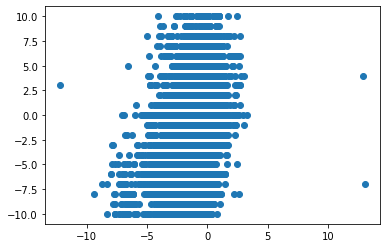

In [112]:
plt.scatter(y_pred_train, data.y_train)

### Combine Data and Modeling Capabilities

In [113]:
class model_suite():
    def __init__(self):
        self.models = {}

    def builder(self, regr, x_train, x_test, y_train, y_test):
        if regr == 'nn':
            vanilla = NN()
            regressor, y_predict_train, y_predict_test = vanilla.Vanilla_NN_Reg(x_train = x_train, x_test = x_test, y_train = y_train)
            train_score = vanilla.Score(regressor, x_train, y_train)
            test_score = vanilla.Score(regressor, x_test, y_test)
            print(f'Basic Model... {regr}')
            print(f'Train Score: {train_score}')
            print(f'Test Score: {test_score}')
            print('.................. \n')
            # -------------------------------
            return regressor

    def model_run(self, regr, x_train, x_test, y_train, y_test):
        self.models['test_model'] = self.builder(regr, x_train, x_test, y_train, y_test)

models = model_suite()
models.model_run(regr='nn',x_train=data.x_train, x_test=data.x_test, y_train=data.y_train, y_test=data.y_test)

Basic Model... nn
Train Score: 0.08914622641393599
Test Score: 0.15358331787573642
.................. 



In [82]:
data.x_train

,expected_lead_time,material_order_history,avg_material_late,supplier_material_order_history,avg_supplier_material_late,supplier_total_order_history,avg_supplier_general_late,number_line_items,avg_MOQ,avg_unit_price,...,dayofweek-Monday,dayofweek-Saturday,dayofweek-Sunday,dayofweek-Thursday,dayofweek-Tuesday,dayofweek-Wednesday,delivery_season-Fall,delivery_season-Spring,delivery_season-Summer,delivery_season-Winter
0,84.0,321.0,-6.476636,27.0,4.037037,28.0,4.035714,25,0.440273,517.727440,...,0,0,0,0,0,0,0,1,0,0
1,78.0,2332.0,-6.687590,7.0,-3.285714,349.0,-2.155224,1,0.000268,52.358737,...,0,0,0,0,0,0,0,1,0,0
2,1.0,6109.0,0.255852,5449.0,0.272392,5449.0,0.272392,1,31012.938776,17.964587,...,0,0,0,0,0,0,0,1,0,0
3,7.0,31199.0,-0.501606,30055.0,-0.395743,30067.0,-0.394674,17,868.658120,3.905899,...,0,0,0,0,0,0,0,1,0,0
4,84.0,321.0,-6.476636,27.0,4.037037,28.0,4.035714,25,0.440273,517.727440,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59698,7.0,31199.0,-0.501606,30055.0,-0.395743,30067.0,-0.394674,30,868.658120,3.905899,...,0,0,0,0,0,0,0,1,0,0
59699,7.0,31199.0,-0.501606,30055.0,-0.395743,30067.0,-0.394674,30,868.658120,3.905899,...,0,0,0,0,0,0,0,1,0,0
59701,2.0,11390.0,-2.278994,11388.0,-2.279195,11866.0,-2.288488,11,2678.519713,1.988488,...,0,0,0,0,0,0,0,1,0,0
59702,7.0,31199.0,-0.501606,30055.0,-0.395743,30067.0,-0.394674,30,868.658120,3.905899,...,0,0,0,0,0,0,0,1,0,0


In [71]:
# corr = df[
# features
# ].corr()
# fig = px.imshow(corr)
# fig.show()